In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
% matplotlib inline
import pandas as pd

In [2]:
## Data Source: https://www.kaggle.com/manjeetsingh/retaildataset
# read the ['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv'] from the /data folder
import os
print("current directory is : " + os.getcwd()) 
print('the /data folder contains:') 
print(os.listdir("./data"))

stores = pd.read_csv('./data/stores data-set.csv')
features = pd.read_csv('./data/Features data set.csv')
sales = pd.read_csv('./data/sales data-set.csv')

## I don't intend to use so instead of replacing na-s with 0 I better drop them all
markdown_cols = features.filter(like='MarkDown').columns
for column in markdown_cols:
     features = features.drop(column,axis=1)

# On features Fill na gaps forward on CPI and Unemployment, Data seems sorted by date already
# https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
features['CPI'] = features['CPI'].fillna(method='pad')
features['Unemployment'] = features['Unemployment'].fillna(method='pad')

current directory is : C:\Users\User\projects\retail_kaggle
the /data folder contains:
['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv']


In [3]:
# merge left all tables, use only keys from left frame, similar to a SQL left outer join; preserve key order.
    
retail = pd.merge(sales, features, how = 'left', on = ['Store', 'Date', 'IsHoliday'])
retail = pd.merge(retail, stores, how = 'left', on = ['Store'])

# format date in datetime, we need it to extract Year and Year week later to split the data in train, test
retail['Date'] = pd.to_datetime(retail['Date'])
retail['Year'] = pd.DatetimeIndex(retail['Date']).year
retail['Month'] = pd.DatetimeIndex(retail['Date']).month

retail['Year-Week'] = retail['Date'].dt.strftime('%Y-%U')

# I noticed there are Sales figures that are negative, cleanup:
retail = retail[retail['Weekly_Sales']>=0]

# turn IsHoliday into an Integer, useful later for numeric computations
retail['IsHoliday'] = retail['IsHoliday'].astype(int)

# Sort by Date as the data is not ordered by Date
retail = retail.sort_values(by=['Date'])

# checkout the dataset we're going to use further
retail.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Year,Month
count,420285.000000,420285.000000,420285.000000,420285.00000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000
mean,22.195477,44.242771,16030.329773,0.07034,60.090474,3.360888,171.212152,7.960077,136749.569176,2010.968443,6.478501
std,12.787213,30.507197,22728.500149,0.25572,18.448260,0.458523,39.162280,1.863873,60992.688568,0.796893,3.324688
min,1.000000,1.000000,0.000000,0.00000,-2.060000,2.472000,126.064000,3.879000,34875.000000,2010.000000,1.000000
25%,11.000000,18.000000,2117.560000,0.00000,46.680000,2.933000,132.022667,6.891000,93638.000000,2010.000000,4.000000
50%,22.000000,37.000000,7659.090000,0.00000,62.090000,3.452000,182.350989,7.866000,140167.000000,2011.000000,6.000000
75%,33.000000,74.000000,20268.380000,0.00000,74.280000,3.738000,212.445487,8.567000,202505.000000,2012.000000,9.000000
max,45.000000,99.000000,693099.360000,1.00000,100.140000,4.468000,227.232807,14.313000,219622.000000,2012.000000,12.000000


In [4]:
# X_col = ['Temperature','Fuel_Price','CPI','Unemployment','Size', 'IsHoliday']

X_col = ['Size']
y_col = ['Weekly_Sales']
X = retail[X_col].values
y = retail[y_col].values

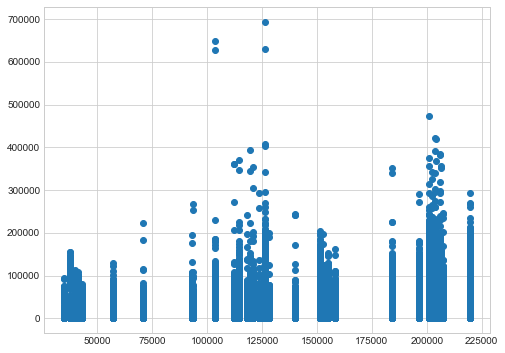

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(X,y)

In [6]:
# Transform to a standard normally distributed data
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y.reshape(-1,1)).flatten()

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


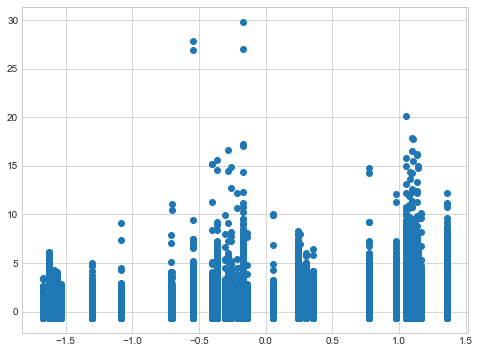

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(X_std,y_std)

In [8]:
X_col = ['Temperature','Fuel_Price','CPI','Unemployment','Size', 'IsHoliday']
y_col = ['Weekly_Sales']
X = retail[X_col]
y = retail[y_col] 

# Split the data in train test using sklearn 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [9]:
# linear model without scaling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
model =  LinearRegression()
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print(mean_squared_error(y_train, y_train_pred))
print("R^2 train: {0:.4f}, test: {1:.4f}".\
      format(r2_score(y_train, y_train_pred),
             r2_score(y_test, y_test_pred)))

490317504.6703065
R^2 train: 0.0602, test: 0.0627


In [10]:
# with preprocessing.scale scaling Mean removal, data is centered on 0
from sklearn import preprocessing
X_train_scaled = preprocessing.scale(X_train)
y_train_scaled = preprocessing.scale(y_train)
X_test_scaled = preprocessing.scale(X_test)
y_test_scaled = preprocessing.scale(y_test)

In [11]:
model =  LinearRegression()
model.fit(X_train_scaled,y_train_scaled)
# Mean Squered error (MSE) best value is 0
y_train_pred_scaled = model.predict(X_train_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)
print(mean_squared_error(y_train_scaled, y_train_pred_scaled))
print("R^2 train: {0:.4f}, test: {1:.4f}".\
      format(r2_score(y_train_scaled, y_train_pred_scaled),
             r2_score(y_test_scaled, y_test_pred_scaled)))

0.9398171822339768
R^2 train: 0.0602, test: 0.0627
